In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load data

In [5]:
data = pd.read_csv('/kaggle/input/bitcoin-stock-data-sept-17-2014-august-24-2021/BTC-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


# Feature Selection and Engineering

In [7]:
data['Daily_Return'] = data['Close'].pct_change()
data['Rolling_Mean'] = data['Close'].rolling(window=5).mean()
data['Rolling_Std'] = data['Close'].rolling(window=5).std()

data = data.dropna()  # Drop rows with NaN values

# Preprocessing

In [8]:
# Scaling the features
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(data[['Close', 'Volume', 'Daily_Return', 
                                                     'Rolling_Mean', 'Rolling_Std']])

In [9]:
# Scaling the target
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(data[['Close']])

In [10]:
# Combine scaled features and target into one dataset
scaled_data = np.concatenate([scaled_features, scaled_target], axis=1)

# Train-Test Split

In [11]:
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Create dataset for LSTM

In [12]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]
        X.append(a)
        Y.append(dataset[i + look_back, -1])
    return np.array(X), np.array(Y)

look_back = 10
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# LSTM Model

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)

2156/2156 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 5.4505e-04


# Predictions

In [14]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [15]:
# Inverse transform predictions to original scale
train_predict = target_scaler.inverse_transform(train_predict)
test_predict = target_scaler.inverse_transform(test_predict)

In [16]:
# Prepare data for plotting
train = data[:train_size]
valid = data[train_size:]
valid['Predictions'] = np.nan
valid.iloc[look_back+1:, valid.columns.get_loc('Predictions')] = test_predict.flatten()

# Plotting results

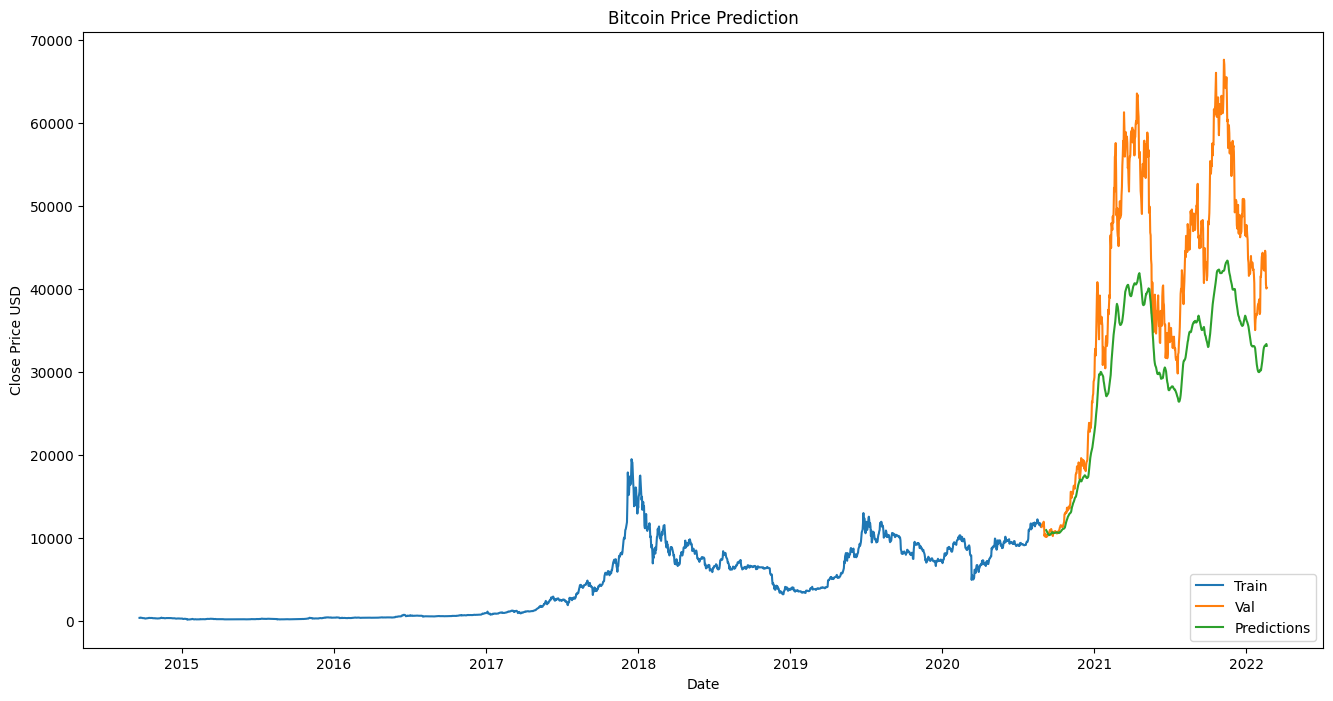

In [17]:
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()